In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-03 21:34:57.713470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 21:34:57.713569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 21:34:57.714438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 21:34:57.720250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 21:34:58.485897: W tensorflow/compiler/tf2

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# Drop rows with missing values
data = data.dropna(saubset=['text', 'label'])

# Remove punctuation and non-ASCII characters
data['text'] = data['text'].str.replace(r'[^\w\s]+', '', regex=True)
data['text'] = data['text'].str.encode('ascii', 'ignore').str.decode('ascii')

# Convert labels to uppercase
data['label'] = data['label'].str.upper()

In [4]:
# # Encode the categorical labels into numerical labels using LabelEncoder
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(labels)

In [5]:
# Split data into training, test, and prediction sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.25, random_state=42)
# X_predict, X_test, y_predict, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Load BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [6]:
# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# y_predict_encoded = label_encoder.transform(y_predict)

In [7]:
# Tokenize input data
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# Tokenize input data with maximum length of 512 tokens
train_encodings = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=512)
# predict_encodings = tokenizer(X_predict.tolist(), padding=True, truncation=True, max_length=512)



# Ensure labels are integers and input data is tokenized
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_encoded)).shuffle(100).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_encoded)).batch(32)
# predict_dataset = tf.data.Dataset.from_tensor_slices((dict(predict_encodings), y_predict_encoded)).batch(64)

In [8]:
# Define optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Load BioBERT model
model = TFAutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(data['label'].unique()))

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
27/27 [==============================] - 1245s 46s/step - loss: 0.6594 - accuracy: 0.5968 - val_loss: 0.5572 - val_accuracy: 0.7431
Epoch 2/10
27/27 [==============================] - 1199s 45s/step - loss: 0.4095 - accuracy: 0.8285 - val_loss: 0.4198 - val_accuracy: 0.8160
Epoch 3/10
27/27 [==============================] - 1205s 45s/step - loss: 0.2463 - accuracy: 0.9038 - val_loss: 0.2631 - val_accuracy: 0.8958
Epoch 4/10
27/27 [==============================] - 1212s 45s/step - loss: 0.1874 - accuracy: 0.9282 - val_loss: 0.3077 - val_accuracy: 0.8785
Epoch 5/10
27/27 [==============================] - 1220s 45s/step - loss: 0.1216 - accuracy: 0.9560 - val_loss: 0.2941 - val_accuracy: 0.9097
Epoch 6/10
27/27 [==============================] - 1195s 44s/step - loss: 0.0723 - accuracy: 0.9803 - val_loss: 0.2717 - val_accuracy: 0.9028
Epoch 7/10
27/27 [==============================] - 1220s 45s/step - loss: 0.0401 - accuracy: 0.9838 - val_loss: 0.2160 - val_accuracy: 0.9340

In [9]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the fine-tuned model
model.save_pretrained("fine_tuned_Bio_ClinicalBERT_model")

9/9 [==============================] - 109s 12s/step - loss: 0.2999 - accuracy: 0.9306
Test Loss: 0.2999454736709595, Test Accuracy: 0.9305555820465088


In [11]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert predicted labels back to original class names
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Convert true labels back to original class names
true_labels = label_encoder.inverse_transform(y_test_encoded)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

9/9 [==============================] - 107s 12s/step
Classification Report:
              precision    recall  f1-score   support

        FAKE       0.94      0.91      0.92       128
        TRUE       0.93      0.95      0.94       160

    accuracy                           0.93       288
   macro avg       0.93      0.93      0.93       288
weighted avg       0.93      0.93      0.93       288

Confusion Matrix:
[[116  12]
 [  8 152]]


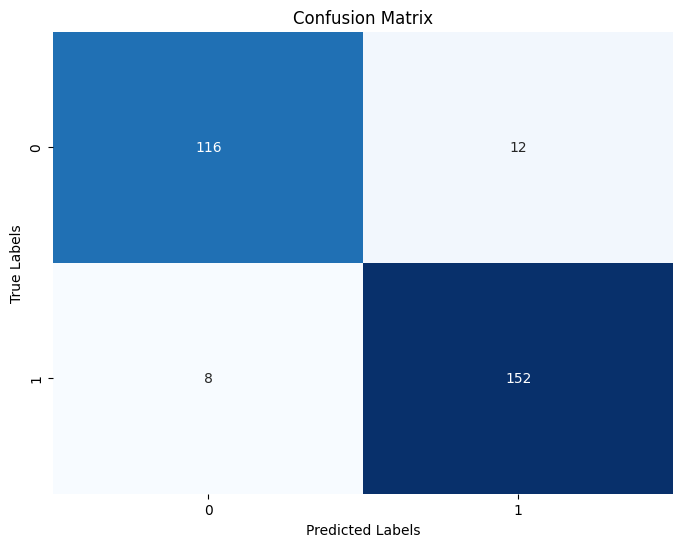

In [13]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
